In [40]:
"""
author: Vetivert? 💐 
created: 13/03/2025 @ 12:46:33
"""

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from prefix_path import full_data_path, redundant_cols, redundant_rows, missing_2017, hematoma_cols, bleeding_cols,\
                        additional_diseases, fillna_values

In [ ]:
# Load dataset
df = pd.read_csv(full_data_path, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(redundant_rows, inplace=True) #indexes of 2019 data 
df.drop(redundant_cols, axis=1, inplace=True)

df = df.fillna(fillna_values) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases

# hematoma group
hema = df[hematoma_cols]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(hematoma_cols[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(hematoma_cols, axis=1, inplace=True)

# bleeding group
bleed = df[bleeding_cols]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(bleeding_cols[0]), 'bleeding', bleed['stacked_int'])
df.drop(bleeding_cols, axis=1, inplace=True)

# additional diseases group
add_diseases = df[additional_diseases]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(additional_diseases[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(additional_diseases, axis=1, inplace=True)



In [ ]:
# strategy 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)
df.drop(missing_2017, axis=1, inplace=True)

df_train = df.loc[:, :'Oliguria'].copy()

x_0_1_2017 = np.random.randint(221, size=(int(0.2 * 222)))
x_0_1_2019 = np.random.randint(203, size=(int(0.2 * 203)))
x_0_1_2019 = x_0_1_2019 + 203 # add 222 to the random numbers to get the correct index

testset_index = x_0_1_2017.tolist() + x_0_1_2019.tolist()
df_test = df_train.iloc[testset_index, :].copy()
df_train.drop(testset_index, inplace=True)

x1_train = df_train.drop(columns=['Diagnosis'], axis=1)
y1_train = df_train['Diagnosis']

x1_test = df_test.drop(columns=['Diagnosis'], axis=1)
y1_test = df_test['Diagnosis']
print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)

rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1.fit(x1_train, y1_train)

y1_pred = rf_1.predict(x1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y1_test, y1_pred))

KeyError: '[225] not found in axis'

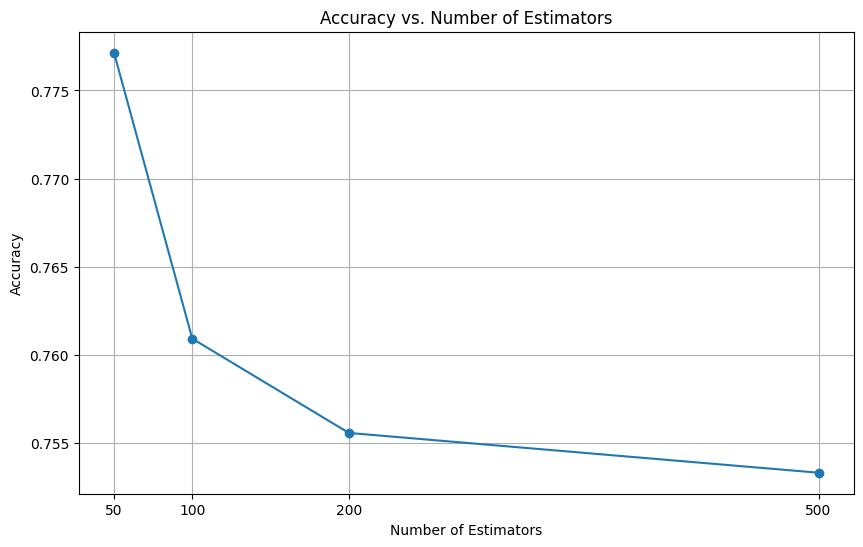

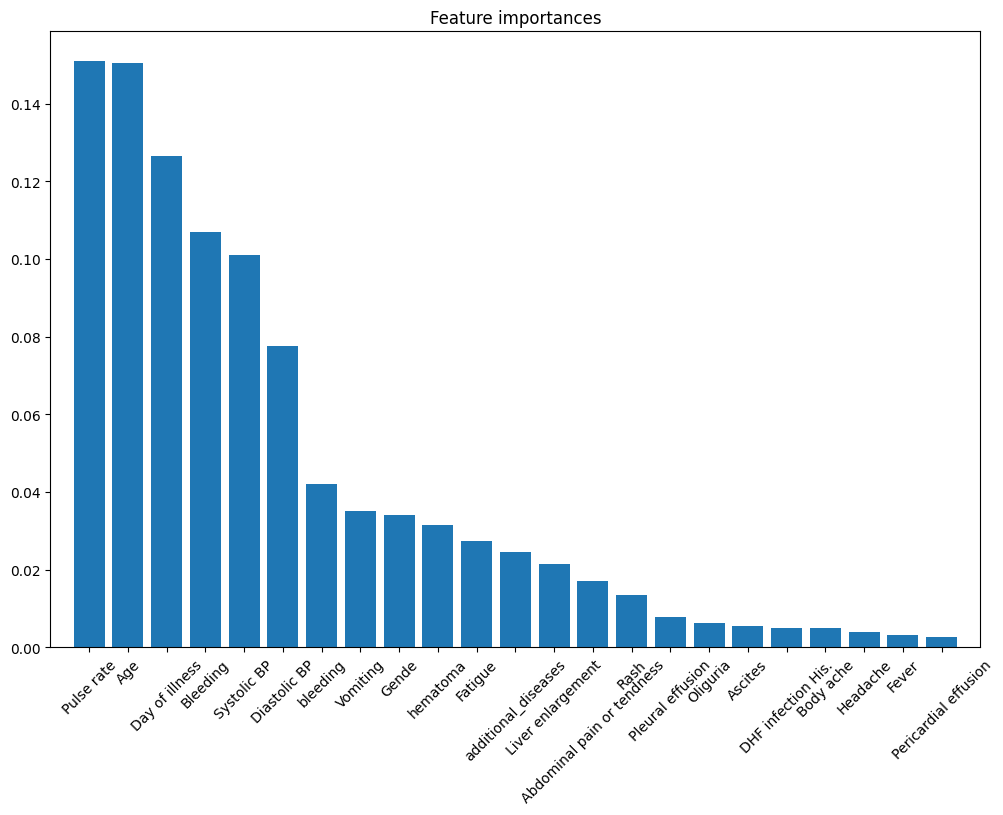

In [84]:
# finding optimal parameters
n_estimators = [50, 100, 200, 500]
n_splits = [5, 10, 20]
accuracy_scores = []

for n in n_estimators:
    for s in n_splits:
        skf = StratifiedKFold(n_splits=s, shuffle=True, random_state=42)
        
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(x1_train, y1_train)
        # y_pred = rf.predict(x1_test)
        scores = cross_val_score(rf, x1_test, y1_test, cv=skf)  # k-fold cross-validation
        # print(n, scores)
        accuracy_scores.append(np.mean(scores))

accuracy_scores = np.array(accuracy_scores)   
# print(len(accuracy_scores))    
accuracy_scores = np.reshape(accuracy_scores, (3,4))
# print(accuracy_scores)
accuracy_scores = accuracy_scores.mean(axis=0)
# print(accuracy_scores)
# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracy_scores, marker='o')
plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.xticks(n_estimators)
plt.grid()
plt.show()

# Plotting feature importances
importances = rf_1.feature_importances_
indices = np.argsort(importances)[::-1]
features = x1_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x1_train.shape[1]), features[indices], rotation=45)
plt.xlim([-1, x1_train.shape[1]])
plt.show()


In [ ]:
# strategy 2, 20% test_set = 0.2 * whole dataset => acc 52% ~ 73%
# df_train = df.loc[:, :'Oliguria'].copy()
X = df_train.drop(columns=['Diagnosis'], axis=1)
Y = df_train['Diagnosis']

x2_train, x2_test, y2_train, y2_test = train_test_split(X, Y, test_size=0.2, random_state=42 )
print('x2_train shape: ', x2_train.shape, 'y2_train shape: ',  y2_train.shape)
print('x2_test shape: ', x2_test.shape, 'y2_test shape: ',  y2_test.shape)

rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2.fit(x2_train, y2_train)

y2_pred = rf_2.predict(x2_test)
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))

x2_train shape:  (267, 23) y2_train shape:  (267,)
x2_test shape:  (67, 23) y2_test shape:  (67,)
Accuracy: 0.73


In [ ]:
# strategy 3: keep missing data 2017  = 'Level of temp' and 'Duration fever', train on 2019 then test on 2017

Accuracy: 0.67


In [63]:
#MR. TEST
# df_train.iloc[0]
# df_test 
df

,Age,Diagnosis,Gende,DHF infection His.,additional_diseases,Fever,Bleeding,Fatigue,Day of illness,Temperature,...,Unnamed: 511,Unnamed: 512,Unnamed: 513,Unnamed: 514,Unnamed: 515,Unnamed: 516,Unnamed: 517,Unnamed: 518,Unnamed: 519,Unnamed: 520
0,46,2,1,0,0,1,0,0,5,"38,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35,1,1,0,0,1,0,0,2,"39,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25,1,0,0,0,1,0,0,3,"36,5",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20,2,1,0,0,1,1,0,5,"39,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31,1,1,0,0,1,0,1,4,"36,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,37,2,0,0,1,1,1,1,4,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,37,2,0,0,1,1,0,1,5,39.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,19,1,1,0,0,1,0,1,6,"37,8",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,44,2,1,0,1,1,0,1,7,39.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
